2 2 48000 443392


C:\Users\ps\.conda\envs\pytorch140\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


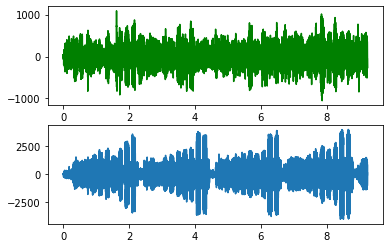

[[   0    0    1 ... -279 -272 -261]
 [   0    1    1 ...  263  102  -65]]


In [99]:
import wave as we
import numpy as np
import matplotlib.pyplot as plt
import random
import os

def wavread(path):
    wavfile =  we.open(path,"rb")
    params = wavfile.getparams()
    # 一次性返回所有格式信息，元组：(声道数, 量化位数（byte单位）, 采样频率, 采样点数, 压缩类型, 压缩类型)
    channel,sampwidth,framesra,frameswav= params[0],params[1],params[2],params[3]
    print(channel,sampwidth,framesra,frameswav)
    datawav = wavfile.readframes(frameswav)
    wavfile.close()
    if sampwidth == 2:
        datause = np.fromstring(datawav,dtype = np.short)
    elif sampwidth==4:
        datause = np.fromstring(datawav,dtype = np.int32)
    datause.shape = -1,channel
    datause = datause.T
    time = np.arange(0, frameswav) * (1.0/framesra)
    return datause,time,framesra



wavdata,wavtime,framesra = wavread("test.wav")
plt.subplot(211)
plt.plot(wavtime, wavdata[0],color = 'green')
plt.subplot(212)
plt.plot(wavtime, wavdata[1])
plt.show()

print(wavdata[:1102])


In [128]:
def MakeData(framerate,baudbyte,number):
    data_len = (int)((framerate/1000)*(1000.0/baudbyte))
    data_beg_len = (int)(data_len*0.9)
    data_end_len = data_len - data_beg_len
    sound_data = np.ones(data_len)
    data_rate = (int)((number+1)*(data_beg_len/100.0))
    sound_data_beg = (np.arange(0, data_beg_len)%data_rate!=0)
    sound_data[0:data_beg_len] = sound_data[0:data_beg_len]*sound_data_beg
    sound_data[data_beg_len:data_len] = 0
    return sound_data
def MakeNoseData(nose_step,nose_len):
    nose_data = (np.arange(0,nose_len)%nose_step==0).astype(np.int32)+((np.arange(0,nose_len)-nose_step)%(nose_step*2)==0).astype(np.int32)
    nose_data = np.where(nose_data>=2,-1,nose_data)
    return nose_data
#采样率,振幅,传输波特率(位/s)，频率Hz(周期/s)
def MakeSinData(framerate,amplitude,bitrate,frequency):
    data_tls = (1.0/bitrate)#总体数据时长
    data_len = int(framerate*data_tls)#数据长度
    data_uns = data_tls/data_len#单个数据时长
    t = np.arange(0, data_tls, data_uns)#时域表
    
    w = (2*np.pi)*frequency[0]/1.0#周期/s
    sound_data = np.sin(t*w)
    for i in range(1,len(frequency)):
        w = (2*np.pi)*frequency[i]/1.0#周期/s
        sound_data = sound_data+np.sin(t*w)
    sound_data = sound_data*amplitude
    return sound_data
def GetNumberByHz(frequencys,hz):
    index = 0
    if hz<frequencys[0]*0.7:
        return -1
    mindic = np.abs(hz-frequencys[0])
    for i in range(0,len(frequencys)):
        dic = np.abs(hz-frequencys[i])
        if mindic>dic:
            mindic  = dic
            index = i
    
    return index
def DrawSound(filename,frequencys,px,bitrate=10,count=10):
    wavdata,wavtime,framesra = wavread(filename)
    data_tls = (1.0/bitrate)#总体数据时长
    data_len = int(framerate*data_tls)#数据长度
    print(data_len)
    plt.plot(wavtime, wavdata[0],color = 'green')
    plt.show()
    
   
    px = px+np.where(wavdata!=0)[1][0]
    for i in range(0,count):
        x = px+i*data_len
        time_tem = wavtime[x:x+data_len]
        data_tem = wavdata[0][x:x+data_len]
       
        fft_size = pow(2,int(np.log2(data_len))) #FFT处理的取样长度
        xs = data_tem[:fft_size]
        xf = np.fft.rfft(xs)
        freqs = np.linspace(0, int(framesra/2), int(fft_size/2+1))
        xfp = np.abs(xf)
        #波形图
        plt.figure(figsize=(8,4))
        plt.subplot(211)
        plt.plot(time_tem[:fft_size], data_tem[:fft_size],color = 'green')
        plt.xlabel(u"Time(S)")
        #频谱图
        index = np.argmax(xfp)
        number = GetNumberByHz(frequencys,freqs[index])
        print(freqs[index],"hz ",number)
        plt.subplot(212)
        plt.plot(freqs, xfp,color = 'red')
        plt.xlabel(u"Freq(Hz)")
        plt.subplots_adjust(hspace=0.4)
        plt.show()
    return wavdata,wavtime,framesra
def GetNumberByFft(sound_data,framesra,frequencys,fft_size):
    xs = sound_data[:fft_size]
    xf = np.fft.rfft(xs)
    freqs = np.linspace(0, int(framesra/2), int(fft_size/2+1))
    xfp =np.abs(xf)
    index = np.argmax(xfp)
    number = GetNumberByHz(frequencys,freqs[index])
    return number
def MakeCrcData(data_str):
    datas = []
    crc_sum = 0
    crc_mul = 0
    for item in data_str:
        number = int(item)
        crc_sum =crc_sum+number
        crc_mul = crc_mul^number
    crc_sum = crc_sum%10
    crc_mul = crc_mul%10
    datas.append(crc_sum)
    datas.append(crc_mul)
    return datas
def MakeTransmissionData(data_str,pack_size):
    datas = []
    count = 0
    if len(data_str)%pack_size!=0:
        print("数据必须是",pack_size,"的倍数!")
    for item in data_str:
        number = int(item)
        datas.append(number)
        count = count+1
        if count%pack_size == 0:
            print(datas)
            crc = MakeCrcData(datas[len(datas)-pack_size:len(datas)])
            datas.append(crc[0])
            datas.append(crc[1])
    return datas
def DeCodeSound(filename,frequencys,bitrate):
    number_list = []
    wavdata,wavtime,framesra = wavread(filename)
    data_tls = (1.0/bitrate)#总体数据时长
    data_len = int(framesra*data_tls)#数据长度
    px = np.where(wavdata!=0)[1][0]
    sound_data = wavdata[0][px:]
    fft_size = int(pow(2,np.log2(data_len)))
    #寻找开始符号 10
    data_index = 0
    while(True):
        data_step = 64#(data_len/2)
        data_x = int(data_index*data_step)
        if(data_x+fft_size>len(sound_data)):
            break
        fft_data = sound_data[data_x:data_x+fft_size]
        if(GetNumberByFft(fft_data,framesra,frequencys,fft_size)==10):
            #找到头部 开始寻找数据部
            while(True):
                data_x = int((data_index+1)*data_step)
                if(data_x+fft_size>len(sound_data)):
                    break
                fft_data = sound_data[data_x:data_x+fft_size]
                number = GetNumberByFft(fft_data,framesra,frequencys,fft_size)
                if(number!=10 and number!=-1):
                    number_list.append(number)
                    break
                data_index = data_index+1
        data_index = data_index+1
    return number_list
def EnCodeSound(datas,baudbyte,frequencys,framerate,pad):
    wave_data = []
    for data in datas:
        freq_start = np.linspace(frequencys[len(frequencys)-1], frequencys[len(frequencys)-1]+pad,int(pad/2))
        freq_date = np.linspace(frequencys[data],frequencys[data]+pad,int(pad/2))
        wave_data = np.append(wave_data,MakeSinData(framerate,1000,baudbyte,(freq_start)))
        wave_data = np.append(wave_data,MakeSinData(framerate,1000,baudbyte,(freq_date)))
    wave_data = wave_data.astype(np.short)
    return wave_data
def DeCodeTransmissionData(datas,pack_size):
    index = 0
    decode_datas = []
    while(True):
        if index+pack_size>len(datas)-2:
            break
        data_part = datas[index:index+pack_size]
        data_crc1 = datas[index+pack_size]
        data_crc2 = datas[index+pack_size+1]
        crc = MakeCrcData(data_part)
        if data_crc1 == crc[0] and data_crc2 == crc[1]:
            decode_datas.append(data_part)
            index = index+pack_size+2
        else:
            index = index+1
    return decode_datas

In [134]:
datas = MakeTransmissionData("012345678901023",15)
trdatas = DeCodeTransmissionData(datas,15)
print(datas)

print(trdatas)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 2, 3]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 2, 3, 1, 1]
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 2, 3]]


In [140]:
framerate = 48000
baudbyte = 128 #bit/s
packsize = 15
#frequencys = np.array([1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,8000])
frequencys = np.linspace(1000,10000,11)
frequencys[len(frequencys)-1] = frequencys[len(frequencys)-1]*0.5
print(frequencys)
datas = MakeTransmissionData("012345678901023",packsize)
wave_data =[]
for i in range(1000):
    #wave_data = np.append(wave_data,MakeSinData(framerate,1000,baudbyte,(freq_date)))
    wave_data_tem = EnCodeSound(datas,baudbyte,frequencys,framerate,2)
    wave_data.append(wave_data_tem)
wave_data = np.array(wave_data)
#帧率
print(wave_data.shape)

# 打开WAV文档
f = we.open("data.wav","wb")
# 配置声道数、每帧的字节数和帧率
f.setnchannels(1)
f.setsampwidth(2)
f.setframerate(framerate)
# 将wav_data转换为二进制数据写入文件
f.writeframes(wave_data.tostring())
f.close()
#DrawSound("data.wav",frequencys,0,baudbyte,20)

[1000. 1900. 2800. 3700. 4600. 5500. 6400. 7300. 8200. 9100. 5000.]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 2, 3]
(1000, 12750)


C:\Users\ps\.conda\envs\pytorch140\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


In [141]:
datas = DeCodeSound("5.wav",frequencys,baudbyte)
tdatas = DeCodeTransmissionData(datas,packsize)
print(len(tdatas))
print(tdatas)
#2022030515063750
#DrawSound("5.wav",frequencys,0,baudbyte,2000)

2 2 48000 12731392


C:\Users\ps\.conda\envs\pytorch140\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


976
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 2, 3], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 2, 3], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 2, 3], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 2, 3], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 2, 3], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 2, 3], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 2, 3], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 2, 3], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 2, 3], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 2, 3], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 2, 3], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 2, 3], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 2, 3], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 2, 3], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 2, 3], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 2, 3], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 2, 3], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 2, 3], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 2, 3], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 2, 3], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 2, 3], [0, 1, 2

996.09375


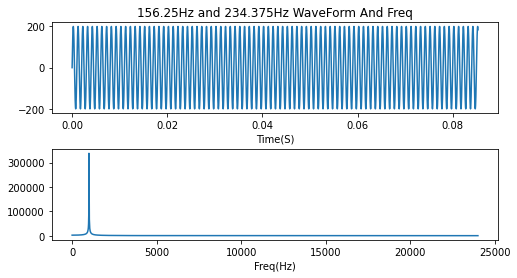

In [279]:
import numpy as np#导入一个数据处理模块
import pylab as pl#导入一个绘图模块，matplotlib下的模块

sampling_rate = 48000#采样频率为8000Hz
fft_size = pow(2,12) #FFT处理的取样长度
t = np.arange(0, 1.0, 1.0/sampling_rate)
x = MakeSinData(sampling_rate,100,10,(1000,1000))
x = x.astype(np.short)
xs = x[:fft_size]
xf = np.fft.rfft(xs)
freqs = np.linspace(0, int(sampling_rate/2), int(fft_size/2+1))
xfp = np.abs(xf)
print(freqs[np.argmax(xfp)])
#绘图显示结果
pl.figure(figsize=(8,4))
pl.subplot(211)
pl.plot(t[:fft_size], xs)
pl.xlabel(u"Time(S)")
pl.title(u"156.25Hz and 234.375Hz WaveForm And Freq")
pl.subplot(212)
pl.plot(freqs, xfp)
pl.xlabel(u"Freq(Hz)")
pl.subplots_adjust(hspace=0.4)
pl.show()

In [5]:
filename = 'data.wav'
os.system('mpg123'+ filename)

1